C:\Users\Gašper Harej\AppData\Local\Temp\ipykernel_14692\1257111631.py:290: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig("signals_time_and_spectrum.png", dpi=300)


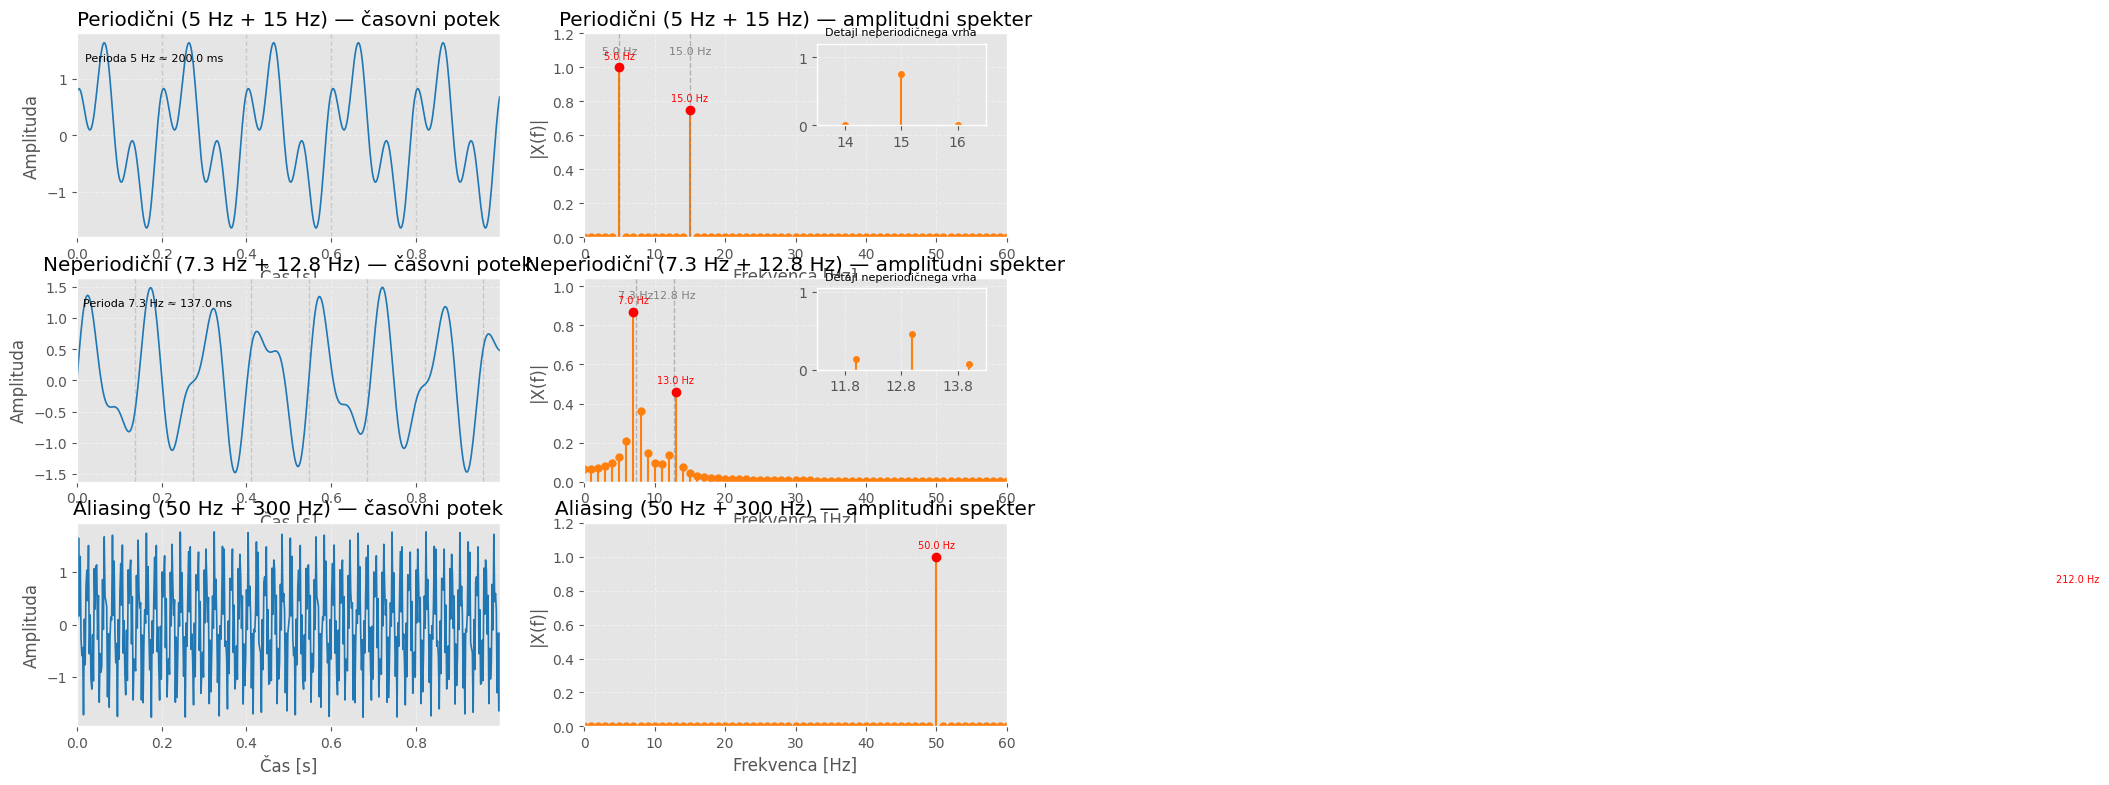

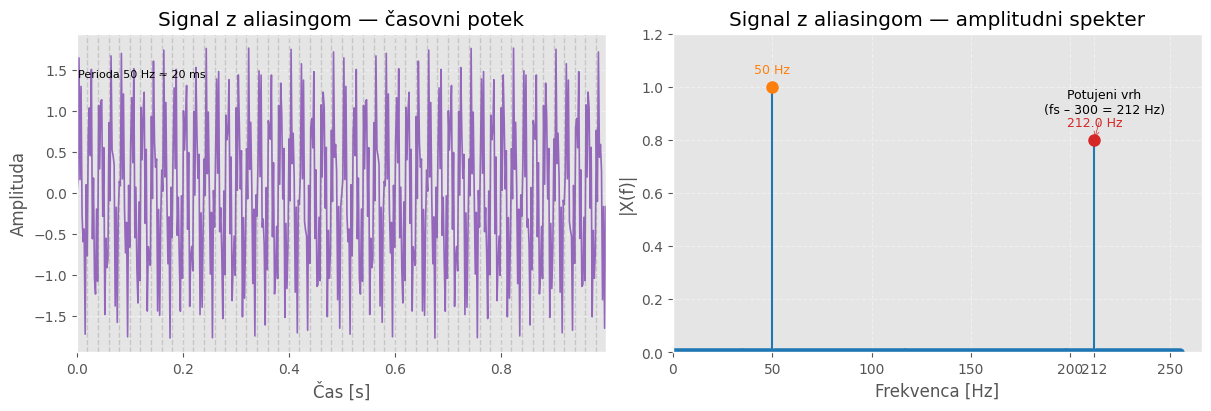

Maksimalne absolutne napake rekonstrukcije in RMS napake:
  Periodični (5 Hz + 15 Hz):        max_abs_err = 8.88e-16,    RMS_err = 2.37e-16
  Neperiodični (7.3 Hz + 12.8 Hz):        max_abs_err = 6.66e-16,    RMS_err = 2.06e-16
  Aliasing (50 Hz + 300 Hz):        max_abs_err = 6.66e-16,    RMS_err = 2.32e-16


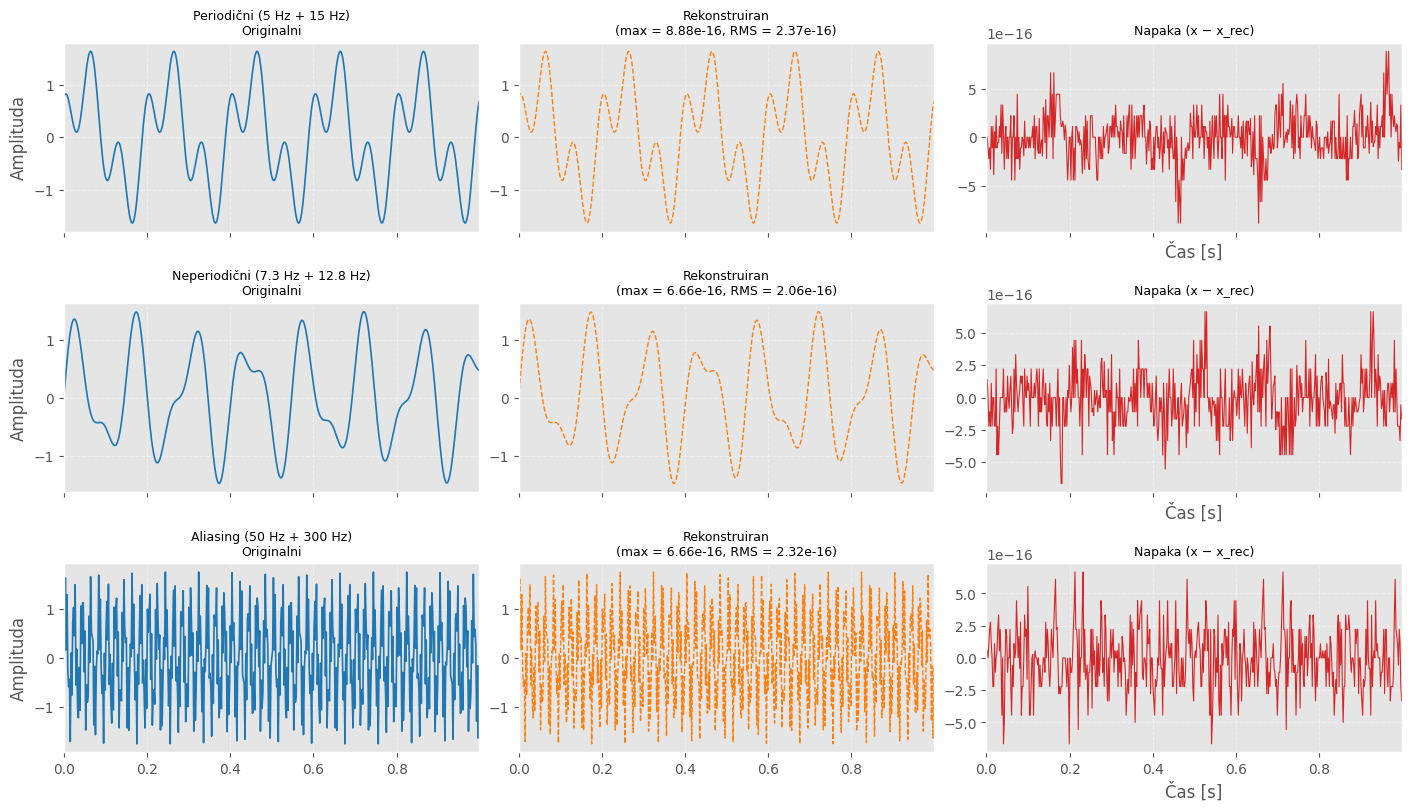

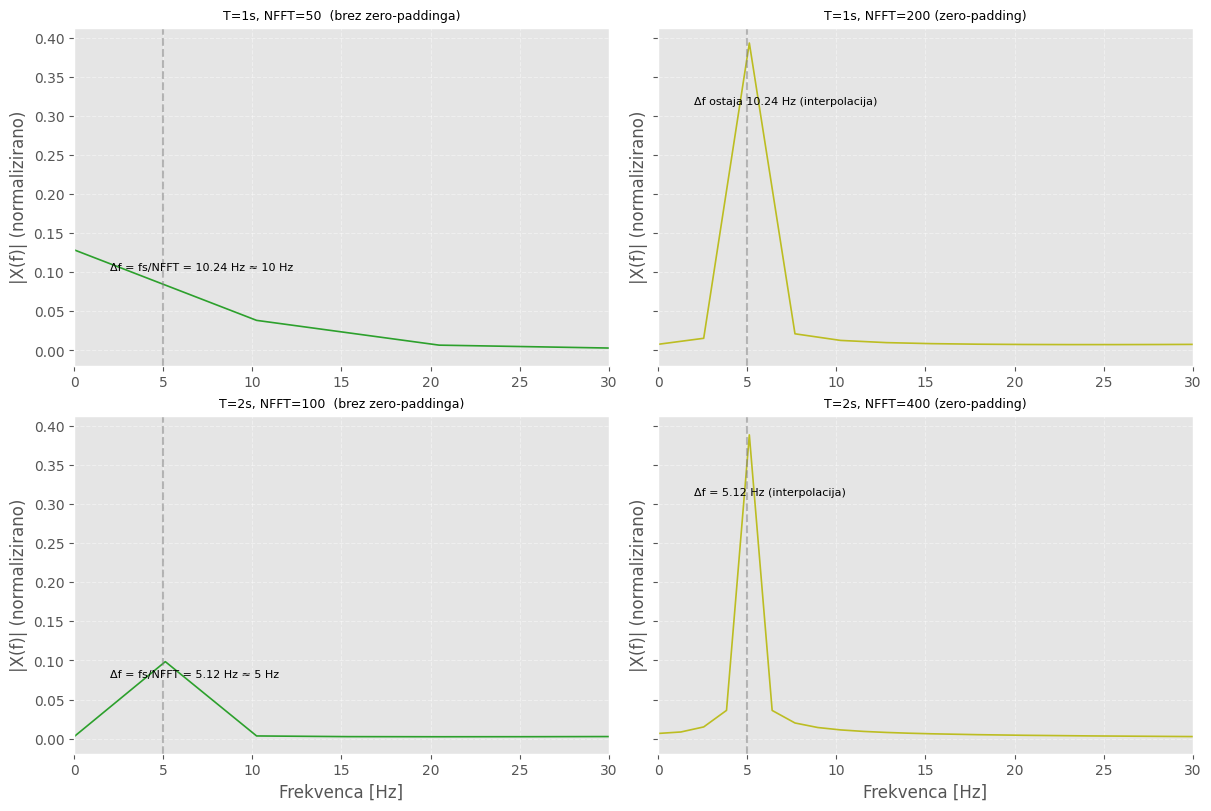

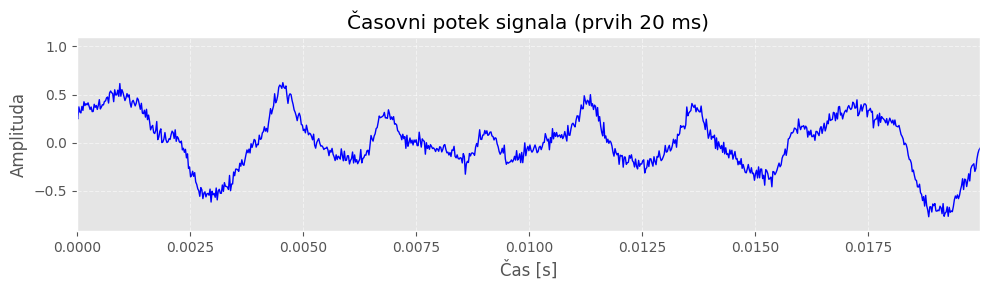

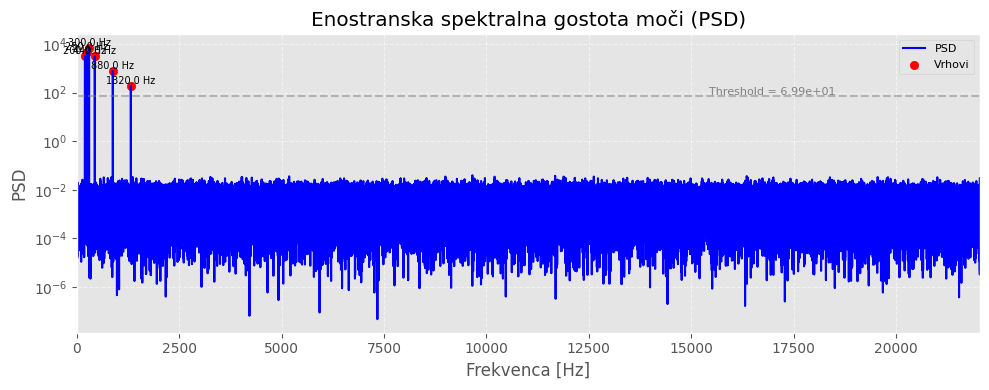

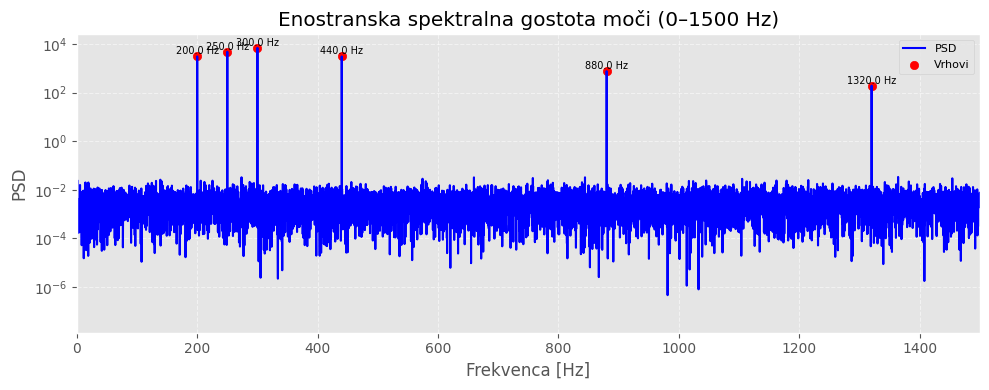

Detected prominent frequencies (Hz):
200.00
250.00
300.00
440.00
880.00
1320.00


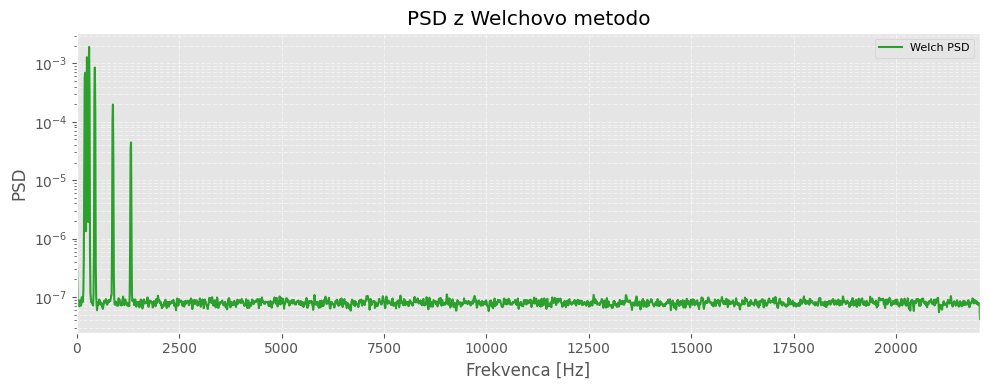

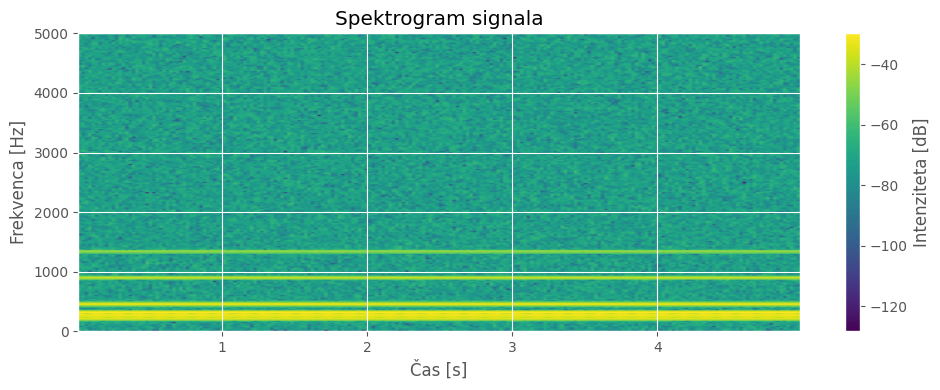

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch

fs = 512.0
f_nyquist = fs / 2
T = 1.0
N = int(T * fs)
t = np.linspace(0, T, N, endpoint=False)

x_periodic = np.sin(2 * np.pi * 5 * t) + 0.75 * np.cos(2 * np.pi * 15 * t)
x_nonperiodic = np.sin(2 * np.pi * 7.3 * t) + 0.5 * np.sin(2 * np.pi * 12.8 * t)
x_alias = np.sin(2 * np.pi * 50 * t) + 0.8 * np.sin(2 * np.pi * 300 * t)

signals = {
    "Periodični (5 Hz + 15 Hz)":        x_periodic,
    "Neperiodični (7.3 Hz + 12.8 Hz)":  x_nonperiodic,
    "Aliasing (50 Hz + 300 Hz)":        x_alias
}

def plot_time_and_spectrum(t, x, fs, ax_time, ax_spec, title, frekvence=None):
    N = len(x)
    dt = 1 / fs
    f_nyquist = fs / 2

    ax_time.plot(t, x, color='tab:blue', linewidth=1.2)
    ax_time.set_title(f"{title} — časovni potek")
    ax_time.set_xlabel("Čas [s]")
    ax_time.set_ylabel("Amplituda")
    ax_time.grid(True, linestyle='--', alpha=0.4)
    ax_time.set_xlim(0, t[-1])
    ylim_min, ylim_max = np.min(x) * 1.1, np.max(x) * 1.1
    ax_time.set_ylim(ylim_min, ylim_max)

    if frekvence is not None and len(frekvence) > 0:
        f0 = frekvence[0]
        period = 1 / f0
        for k in range(int(np.floor(t[-1] / period)) + 1):
            ax_time.axvline(k * period, color='grey', alpha=0.3, linestyle='--', linewidth=1)
        ax_time.text(period * 0.1, np.max(x) * 0.8,
                     f"Perioda {f0} Hz ≈ {period * 1000:.1f} ms",
                     fontsize=8, color='black')

    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=dt)
    idx = (freqs >= 0) & (freqs <= f_nyquist)
    amplitude = np.abs(X[idx]) / (N / 2)

    markerline, stemlines, baseline = ax_spec.stem(
        freqs[idx], amplitude,
        linefmt='tab:orange', markerfmt='tab:orange', basefmt=" "
    )
    plt.setp(markerline, markersize=5)
    ax_spec.set_title(f"{title} — amplitudni spekter")
    ax_spec.set_xlabel("Frekvenca [Hz]")
    ax_spec.set_ylabel("|X(f)|")
    xlim_max = 60 if (not frekvence) else max(60, frekvence[-1] * 1.5)
    ax_spec.set_xlim(0, xlim_max)
    ylim_spec = np.max(amplitude) * 1.2
    ax_spec.set_ylim(0, ylim_spec)
    ax_spec.grid(True, linestyle='--', alpha=0.4)

    if frekvence is not None:
        for f in frekvence:
            if 0 < f < f_nyquist:
                ax_spec.axvline(f, color='grey', alpha=0.5, linestyle='--', linewidth=1)
                ax_spec.text(f, ylim_spec * 0.9, f"{f:.1f} Hz",
                             color='grey', fontsize=8, ha='center')

    peak_indices, _ = find_peaks(amplitude, height=0.1 * np.max(amplitude), distance=3)
    for i in peak_indices:
        f_peak = freqs[idx][i]
        amp_peak = amplitude[i]
        ax_spec.plot(f_peak, amp_peak, 'o', color='red', markersize=6)
        ax_spec.text(f_peak, amp_peak + 0.05 * np.max(amplitude),
                     f"{f_peak:.1f} Hz", color='red', fontsize=7, ha='center')

    if frekvence is not None and len(frekvence) > 1:
        f_center = frekvence[1]
        ax_ins = ax_spec.inset_axes([0.55, 0.55, 0.4, 0.4])
        markerline2, stemlines2, baseline2 = ax_ins.stem(
            freqs[idx], amplitude,
            linefmt='tab:orange', markerfmt='tab:orange', basefmt=" "
        )
        plt.setp(markerline2, markersize=4)
        ax_ins.set_xlim(f_center - 1.5, f_center + 1.5)
        ax_ins.set_ylim(0, ylim_spec)
        ax_ins.grid(True, linestyle='--', alpha=0.4)
        ax_ins.set_xticks([f_center - 1, f_center, f_center + 1])
        ax_ins.set_title("Detajl neperiodičnega vrha", fontsize=8)

    return freqs, amplitude

def plot_aliasing_signal(t, x, fs, ax_time, ax_spec):
    N = len(x)
    dt = 1 / fs
    f_nyquist = fs / 2

    ax_time.plot(t, x, color='tab:purple', linewidth=1.2)
    ax_time.set_title("Signal z aliasingom — časovni potek")
    ax_time.set_xlabel("Čas [s]")
    ax_time.set_ylabel("Amplituda")
    ax_time.grid(True, linestyle='--', alpha=0.4)
    ax_time.set_xlim(0, t[-1])
    ylim_min, ylim_max = np.min(x) * 1.1, np.max(x) * 1.1
    ax_time.set_ylim(ylim_min, ylim_max)

    period_50 = 1 / 50
    for k in range(int(np.floor(t[-1] / period_50)) + 1):
        ax_time.axvline(k * period_50, color='grey', alpha=0.3, linestyle='--', linewidth=1)
    ax_time.text(period_50 * 0.1, np.max(x) * 0.8, "Perioda 50 Hz ≈ 20 ms",
                 color='black', fontsize=8)

    X = np.fft.fft(x)
    freqs = np.fft.fftfreq(N, d=dt)
    idx = (freqs >= 0) & (freqs <= f_nyquist)
    amplitude = np.abs(X[idx]) / (N / 2)

    markerline, stemlines, baseline = ax_spec.stem(
        freqs[idx], amplitude,
        linefmt='tab:blue', markerfmt='tab:blue', basefmt=" "
    )
    plt.setp(markerline, markersize=5)
    ax_spec.set_title("Signal z aliasingom — amplitudni spekter")
    ax_spec.set_xlabel("Frekvenca [Hz]")
    ax_spec.set_ylabel("|X(f)|")

    ax_spec.set_xlim(0, f_nyquist + 10)
    ylim_spec = np.max(amplitude) * 1.2
    ax_spec.set_ylim(0, ylim_spec)
    ax_spec.set_xticks([0, 50, 100, 150, 200, 212, 250])
    ax_spec.grid(True, linestyle='--', alpha=0.4)

    idx_50 = np.argmin(np.abs(freqs - 50))
    amp_50 = np.abs(X[idx_50]) / (N / 2)
    ax_spec.plot(50, amp_50, 'o', color='tab:orange', markersize=8)
    ax_spec.text(50, amp_50 + 0.05, "50 Hz", color='tab:orange', fontsize=9, ha='center')

    f_alias = fs - 300.0
    idx_alias = np.argmin(np.abs(freqs - f_alias))
    amp_alias = np.abs(X[idx_alias]) / (N / 2)
    ax_spec.plot(f_alias, amp_alias, 'o', color='tab:red', markersize=8)
    ax_spec.text(f_alias, amp_alias + 0.05, f"{f_alias:.1f} Hz", color='tab:red', fontsize=9, ha='center')

    tekst_y = amp_alias + 0.1 * np.max(amplitude)
    tekst_x = f_alias + 5
    if tekst_x > f_nyquist:
        tekst_x = f_alias - 25
    ax_spec.annotate("Potujeni vrh\n(fs – 300 = 212 Hz)",
                     xy=(f_alias, amp_alias),
                     xytext=(tekst_x, tekst_y),
                     fontsize=9,
                     ha='center',
                     arrowprops=dict(arrowstyle="->", color='tab:red'))

    return freqs, amplitude

def plot_inverse_and_error(t, signals, fs):
    fig, axes = plt.subplots(len(signals), 3, figsize=(14, 8), sharex=True, constrained_layout=True)
    if len(signals) == 1:
        axes = [axes]

    print("Maksimalne absolutne napake rekonstrukcije in RMS napake:")
    for idx, (name, x) in enumerate(signals.items()):
        ax_orig = axes[idx][0]
        ax_rec = axes[idx][1]
        ax_err = axes[idx][2]

        Nsig = len(x)
        X = np.fft.fft(x)
        x_rec = np.fft.ifft(X).real

        err = x - x_rec
        max_err = np.max(np.abs(err))
        rms_err = np.sqrt(np.mean(err ** 2))
        print(f"  {name}:        max_abs_err = {max_err:.2e},    RMS_err = {rms_err:.2e}")

        ax_orig.plot(t, x, color='tab:blue', linewidth=1.2)
        ax_orig.set_title(f"{name}\nOriginalni", fontsize=9)
        ax_orig.set_ylabel("Amplituda")
        ax_orig.grid(True, linestyle='--', alpha=0.4)
        ax_orig.set_xlim(0, t[-1])
        ax_orig.set_ylim(np.min(x) * 1.1, np.max(x) * 1.1)

        ax_rec.plot(t, x_rec, color='tab:orange', linewidth=1.0, linestyle='--')
        ax_rec.set_title(f"Rekonstruiran\n(max = {max_err:.2e}, RMS = {rms_err:.2e})", fontsize=9)
        ax_rec.grid(True, linestyle='--', alpha=0.4)
        ax_rec.set_xlim(0, t[-1])
        ax_rec.set_ylim(np.min(x_rec) * 1.1, np.max(x_rec) * 1.1)

        ax_err.plot(t, err, color='tab:red', linewidth=0.8)
        ax_err.set_title("Napaka (x − x_rec)", fontsize=9)
        ax_err.set_xlabel("Čas [s]")
        ax_err.grid(True, linestyle='--', alpha=0.4)
        ax_err.set_xlim(0, t[-1])
        ax_err.set_ylim(np.min(err) * 1.1, np.max(err) * 1.1)

    plt.savefig("signals_inverse_reconstruction.png", dpi=300)
    plt.show()

def plot_length_and_fft_effect(fs):
    f_nyquist = fs / 2
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True, constrained_layout=True)

    T1, NFFT1 = 1.0, 50
    N1 = int(T1 * fs)
    t1 = np.arange(N1) / fs
    x1 = np.sin(2 * np.pi * 5 * t1) + 0.5 * np.sin(2 * np.pi * 60 * t1)
    X1 = np.fft.fft(x1, n=NFFT1)
    freqs1 = np.fft.fftfreq(NFFT1, d=1 / fs)
    idx1 = (freqs1 >= 0) & (freqs1 <= f_nyquist)
    amplitude1 = np.abs(X1[idx1]) / (N1 / 2)

    ax = axes[0, 0]
    ax.plot(freqs1[idx1], amplitude1, color='tab:green', linewidth=1.2)
    ax.set_title("T=1s, NFFT=50  (brez zero-paddinga)", fontsize=9)
    ax.set_xlim(0, 30)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.axvline(5, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(60, color='grey', linestyle='--', alpha=0.5)
    ax.text(2, np.max(amplitude1) * 0.8, "Δf = fs/NFFT = 10.24 Hz ≈ 10 Hz", fontsize=8)

    NFFT2 = 200
    X2 = np.fft.fft(x1, n=NFFT2)
    freqs2 = np.fft.fftfreq(NFFT2, d=1 / fs)
    idx2 = (freqs2 >= 0) & (freqs2 <= f_nyquist)
    amplitude2 = np.abs(X2[idx2]) / (N1 / 2)

    ax = axes[0, 1]
    ax.plot(freqs2[idx2], amplitude2, color='tab:olive', linewidth=1.2)
    ax.set_title("T=1s, NFFT=200 (zero-padding)", fontsize=9)
    ax.set_xlim(0, 30)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.axvline(5, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(60, color='grey', linestyle='--', alpha=0.5)
    ax.text(2, np.max(amplitude2) * 0.8, "Δf ostaja 10.24 Hz (interpolacija)", fontsize=8)

    T3, NFFT3 = 2.0, 100
    N3 = int(T3 * fs)
    t3 = np.arange(N3) / fs
    x3 = np.sin(2 * np.pi * 5 * t3) + 0.5 * np.sin(2 * np.pi * 60 * t3)
    X3 = np.fft.fft(x3, n=NFFT3)
    freqs3 = np.fft.fftfreq(NFFT3, d=1 / fs)
    idx3 = (freqs3 >= 0) & (freqs3 <= f_nyquist)
    amplitude3 = np.abs(X3[idx3]) / (N3 / 2)

    ax = axes[1, 0]
    ax.plot(freqs3[idx3], amplitude3, color='tab:green', linewidth=1.2)
    ax.set_title("T=2s, NFFT=100  (brez zero-paddinga)", fontsize=9)
    ax.set_xlim(0, 30)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.axvline(5, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(60, color='grey', linestyle='--', alpha=0.5)
    ax.text(2, np.max(amplitude3) * 0.8, "Δf = fs/NFFT = 5.12 Hz ≈ 5 Hz", fontsize=8)

    NFFT4 = 400
    X4 = np.fft.fft(x3, n=NFFT4)
    freqs4 = np.fft.fftfreq(NFFT4, d=1 / fs)
    idx4 = (freqs4 >= 0) & (freqs4 <= f_nyquist)
    amplitude4 = np.abs(X4[idx4]) / (N3 / 2)

    ax = axes[1, 1]
    ax.plot(freqs4[idx4], amplitude4, color='tab:olive', linewidth=1.2)
    ax.set_title("T=2s, NFFT=400 (zero-padding)", fontsize=9)
    ax.set_xlim(0, 30)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.axvline(5, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(60, color='grey', linestyle='--', alpha=0.5)
    ax.text(2, np.max(amplitude4) * 0.8, "Δf = 5.12 Hz (interpolacija)", fontsize=8)

    for ax in axes.flat:
        ax.set_ylabel("|X(f)| (normalizirano)")

    axes[-1, 0].set_xlabel("Frekvenca [Hz]")
    axes[-1, 1].set_xlabel("Frekvenca [Hz]")
    plt.savefig("fft_length_and_effect.png", dpi=300)
    plt.show()

fig, axes = plt.subplots(len(signals), 2, figsize=(12, 9), constrained_layout=True)
for i, (name, x) in enumerate(signals.items()):
    if "Periodični" in name:
        frekvence = [5, 15]
    elif "Neperiodični" in name:
        frekvence = [7.3, 12.8]
    else:
        frekvence = None
    freqs, amplitude = plot_time_and_spectrum(
        t, x, fs, axes[i, 0], axes[i, 1], title=name, frekvence=frekvence
    )
plt.savefig("signals_time_and_spectrum.png", dpi=300)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
plot_aliasing_signal(t, x_alias, fs, axs[0], axs[1])
plt.savefig("signal_aliasing.png", dpi=300)
plt.show()

plot_inverse_and_error(t, signals, fs)
plot_length_and_fft_effect(fs)

filename = "waveform.txt"
fs_wav = 44100
nyquist_wav = fs_wav / 2

data = np.loadtxt(filename)
N_wav = len(data)
t_wav = np.arange(N_wav) / fs_wav

plt.figure(figsize=(10, 3))
limit = int(0.02 * fs_wav)
plt.plot(t_wav[:limit], data[:limit], color='blue', linewidth=1)
plt.title('Časovni potek signala (prvih 20 ms)')
plt.xlabel('Čas [s]')
plt.ylabel('Amplituda')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(0, t_wav[limit-1])
plt.ylim(np.min(data) * 1.1, np.max(data) * 1.1)
plt.tight_layout()
plt.savefig("waveform_time_domain.png", dpi=300)
plt.show()

X_wav = np.fft.rfft(data)
freqs_wav = np.fft.rfftfreq(N_wav, 1 / fs_wav)
PSD = (2.0 / N_wav) * np.abs(X_wav) ** 2

threshold = 0.01 * np.max(PSD)
peaks, _ = find_peaks(PSD, height=threshold, distance=5)
peak_freqs = freqs_wav[peaks]
peak_heights = PSD[peaks]

plt.figure(figsize=(10, 4))
plt.semilogy(freqs_wav, PSD, label='PSD', color='blue')
plt.scatter(peak_freqs, peak_heights, color='red', label='Vrhovi')
plt.axhline(threshold, color='grey', linestyle='--', alpha=0.5)
plt.text(nyquist_wav * 0.7, threshold * 1.2, f"Threshold = {threshold:.2e}", fontsize=8, color='grey')
for f, h in zip(peak_freqs, peak_heights):
    plt.text(f, h, f'{f:.1f} Hz', ha='center', va='bottom', fontsize=7)
plt.title('Enostranska spektralna gostota moči (PSD)')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('PSD')
plt.xlim(0, nyquist_wav)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("waveform_frequency_domain.png", dpi=300)
plt.show()

hz = 1500
plt.figure(figsize=(10, 4))
plt.semilogy(freqs_wav, PSD, label='PSD', color='blue')
plt.scatter(peak_freqs, peak_heights, color='red', label='Vrhovi')
for f, h in zip(peak_freqs, peak_heights):
    if f <= hz:
        plt.text(f, h, f'{f:.1f} Hz', ha='center', va='bottom', fontsize=7)
plt.title(f'Enostranska spektralna gostota moči (0–{hz} Hz)')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('PSD')
plt.xlim(0, hz)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("waveform_frequency_domain_hz.png", dpi=300)
plt.show()

print("Detected prominent frequencies (Hz):")
for f in peak_freqs:
    print(f"{f:.2f}")

f_w, Pxx_w = welch(data, fs_wav, nperseg=4096)
plt.figure(figsize=(10, 4))
plt.semilogy(f_w, Pxx_w, label="Welch PSD", color='tab:green')
plt.title("PSD z Welchovo metodo")
plt.xlabel("Frekvenca [Hz]")
plt.ylabel("PSD")
plt.xlim(0, nyquist_wav)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("waveform_welch_psd.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 4))
Pxx, freqs_s, bins, im = plt.specgram(data, NFFT=2048, Fs=fs_wav, noverlap=1024, cmap='viridis')
plt.colorbar(label="Intenziteta [dB]")
plt.title("Spektrogram signala")
plt.xlabel("Čas [s]")
plt.ylabel("Frekvenca [Hz]")
plt.ylim(0, 5000)
plt.tight_layout()
plt.savefig("waveform_spectrogram.png", dpi=300)
plt.show()
